In [ ]:
%cd "/content/drive/MyDrive/Datasets/Image_Captioning_Dataset"
!ls

/content/drive/MyDrive/Datasets/Image_Captioning_Dataset
dataset.zip


In [ ]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

In [ ]:
!ls

dataset.zip  flickr8k


In [2]:
root_dir = "/content/drive/MyDrive/Datasets/Image_Captioning_Dataset/flickr8k"

In [61]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import spacy # for tokenizer (can use nltk as well)
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

spacy_eng = spacy.load("en")

In [52]:
class Vocabulary(object):
  def __init__(self, freq_threshold):
    self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
    self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
    self.freq_threshold = freq_threshold

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4
    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence):
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1
        if frequencies[word] == self.freq_threshold:
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1
  
  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text)
    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text
    ]

In [73]:
class FDataset(Dataset):
  def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
    self.root_dir = root_dir
    self.df = pd.read_csv(captions_file)
    self.transform = transform

    # Getting the image and captions
    self.imgs = self.df["image"]
    self.captions = self.df["caption"]

    # Initialize vocabulary and build a vocabulary
    self.vocab = Vocabulary(freq_threshold)
    self.vocab.build_vocabulary(self.captions.tolist())
    
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    caption = self.captions[index]
    img_id = self.imgs[index]
    img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
    
    if self.transform is not None:
      img = self.transform(img)
    
    numericalized_caption = [self.vocab.stoi["<SOS>"]]
    numericalized_caption += self.vocab.numericalize(caption)
    numericalized_caption.append(self.vocab.stoi["<EOS>"])

    return img, torch.tensor(numericalized_caption)

In [75]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

In [76]:
def get_loader(root_dir, annotation_file, transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
  dataset = FDataset(root_dir, annotation_file, transform)
  pad_idx = dataset.vocab.stoi["<PAD>"]
  loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, pin_memory=pin_memory, collate_fn=MyCollate(pad_idx))
  return loader

In [79]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

dataloader = get_loader(root_dir+'/images', root_dir+'/captions.txt',transform=transform)
print(len(dataloader))
for idx, (imgs, captions) in enumerate(dataloader):
  print(imgs.shape)
  print(captions.shape)
  if idx == 2:
    break

1265
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
torch.Size([26, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])


Text(0.5, 1.0, 'Little boy in yellow shirt is climbing out of a plastic playground tunnel .')

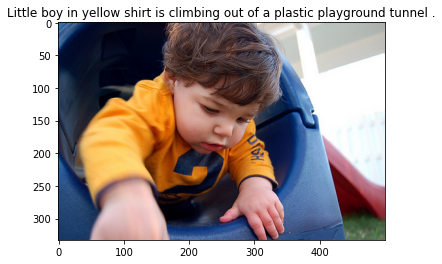

In [41]:
df = pd.read_csv(root_dir + '/captions.txt')
idx = np.random.randint(0,len(df))
img_id = df["image"][idx]
caption = df["caption"][idx]
img = Image.open(os.path.join(root_dir+'/images', img_id)).convert("RGB")
plt.imshow(img)
plt.title(f'{caption}')